In [1]:
import os
if "models" not in os.listdir("."):
    os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2
import penzai
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

In [3]:
from micrlhf.llama import LlamaTransformer
llama = LlamaTransformer.from_pretrained("models/gemma-2b-it.gguf",
                                         from_type="gemma",
                                         load_eager=True
                                         )

In [4]:
!mkdir -p data
import pandas as pd
df_adv = pd.read_csv("data/adv.csv")
format_prompt = """<start_of_turn>user\n
{}\n
<start_of_turn>model\n
{}"""
# offset = 1
# df_do = df.apply(lambda x: format_response.format(x['goal'], x['target']), axis=1)
# prompts_harmful = df.apply(lambda x: format_prompt.format(x['goal'], "")[:-offset], axis=1).to_list()[:100]
prompts_harmful = df_adv.apply(lambda x: format_prompt.format(x['goal'], ""), axis=1).to_list()[:100]
dataset_jail = pd.read_csv("data/jail.csv").apply(lambda x: x["Goal"], axis=1).to_list()
prompts_jail = [format_prompt.format(x, "") for x in dataset_jail]
import datasets
# https://colab.research.google.com/drive/1a-aQvKC9avdZpdyBn4jgRQFObTPy1JZw
hf_path = 'tatsu-lab/alpaca'
dataset = datasets.load_dataset(hf_path)
# filter for instructions that do not have inputs
prompts_harmless = []
for i in range(len(dataset['train'])):
    if len(prompts_harmless) >= len(prompts_harmful):
        break
    if dataset['train'][i]['input'].strip() == '':
        # prompts_harmless.append(format_prompt.format(dataset['train'][i]['instruction'], "")[:-offset])
        prompts_harmless.append(format_prompt.format(dataset['train'][i]['instruction'], ""))

# ds = datasets.load_dataset("MBZUAI/LaMini-instruction", split="train", streaming=True)
# prompts_harmless = []
# for _, text in zip(range(100), ds):
#     prompts_harmless.append(format_prompt.format(text["instruction"], ""))

# ds = datasets.load_dataset("nev/openhermes-2.5-phi-format-text", split="train", streaming=True)
# prompts_harmless = []
# for _, text in zip(range(100), ds):
#     text = text["text"]
#     text = "".join(text.partition("<|assistant|>\n")[:2])
#     prompts_harmless.append(text)

/usr/local/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [5]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("alpindale/gemma-2b")
tokenizer.padding_side = "right"

In [6]:
from micrlhf.sampling import sample, trange, jnp, load_tokenizer, jit_wrapper
import jax

tokens = tokenizer.batch_encode_plus(prompts_harmful + prompts_harmless,
                                     return_tensors="np",
                                     padding="max_length",
                                     truncation=True,
                                     max_length=128,
                                     return_attention_mask=True)
token_array = jnp.asarray(tokens["input_ids"])
token_array = jax.device_put(token_array, jax.sharding.NamedSharding(llama.mesh, jax.sharding.PartitionSpec("dp", "sp")))
token_array = pz.nx.wrap(token_array, "batch", "seq").untag("batch").tag("batch")
inputs = llama.inputs.from_basic_segments(token_array)

In [7]:
from micrlhf.llama import LlamaBlock
from micrlhf.flash import flashify
from micrlhf.sampling import sample, trange, jnp, load_tokenizer, jit_wrapper
get_resids = llama.select().at_instances_of(LlamaBlock).apply_with_selected_index(lambda i, x:
    pz.nn.Sequential([
        pz.de.TellIntermediate.from_config(tag=f"resid_pre_{i}"),
        x
    ])
)
get_resids = pz.de.CollectingSideOutputs.handling(get_resids, tag_predicate=lambda x: x.startswith("resid_pre"))
get_resids_call = jit_wrapper.Jitted(get_resids)
_, resids = get_resids_call(inputs)

/tmp/ipykernel_455751/4119513429.py:13: RuntimeWarning: invalid value encountered in divide
  residiff = residiff / np.linalg.norm(residiff)


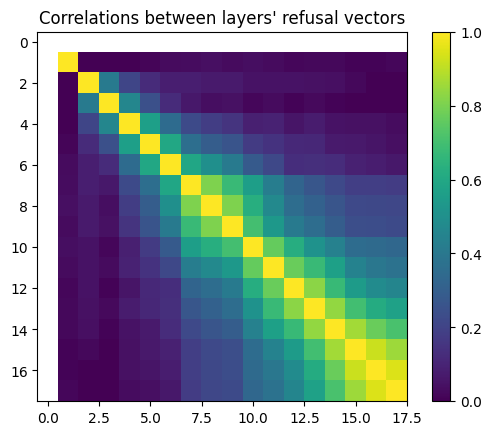

In [8]:
from matplotlib import pyplot as plt
import numpy as np
residiffs = []
last_resids = []
for i, resid in enumerate(sorted(resids, key=lambda x: int(x.tag.rpartition("_")[-1]))):
    resid = resid.value.unwrap("batch", "seq", "embedding")
    indices = jnp.asarray(tokens["attention_mask"].sum(1, keepdims=True))[..., None] - 1
    last_resid = jnp.take_along_axis(resid, indices, 1)[:, 0]
    last_resid = last_resid.reshape(2, -1, last_resid.shape[-1])
    last_resids.append(last_resid)
    last_resid = last_resid.mean(1)
    residiff = np.array(last_resid[0] - last_resid[1])
    residiff = residiff / np.linalg.norm(residiff)
    residiffs.append(residiff)
matmuls = np.matmul(residiffs, np.transpose(residiffs))
norms = np.linalg.norm(residiffs, axis=-1) + 1e-10
plt.title("Correlations between layers' refusal vectors")
plt.imshow(matmuls / norms[:, None] / norms[None, :], vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [9]:
from micrlhf.utils.vector_storage import save_and_upload_vector, download_vector
from micrlhf.utils.load_sae import get_nev_it_sae_suite
from micrlhf.utils.ito import grad_pursuit


sae_k = 4
threshold = 0.2
interesting_features = set()
for layer_sae in range(8, 16):
    dictionary = get_nev_it_sae_suite(layer_sae)["W_dec"]
    dictionary = dictionary / np.linalg.norm(dictionary, axis=1, keepdims=True)
    for layer in range(1, len(residiffs)):
        vector_name = f"gemma-refusal-l{layer}"
        vector = residiffs[layer]
        vector = vector / np.linalg.norm(vector)
        try:
            save_and_upload_vector(vector_name, vector)
        except FileExistsError:
            pass
        weights, recon = grad_pursuit(vector, dictionary, sae_k, pos_only=True)
        w, i = jax.lax.top_k(jnp.abs(weights), sae_k)
        print(f"Layer {layer} -> Layer {layer_sae}: {[(int(a), float(b)) for a, b in zip(i, w)]}")
        for f, u in zip(i, w):
            if u < threshold:
                continue
            interesting_features.add((layer_sae, int(f)))
    print()

--2024-07-19 00:15:45--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l8-residual-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.156.211.90, 108.156.211.51, 108.156.211.125, ...
Connecting to huggingface.co (huggingface.co)|108.156.211.90|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/ac42c841f31e9b75c96c4e9654d9d0bdc8a1037371b106ab8f7a450847c773f6?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1721607345&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMTYwNzM0NX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgv

Layer 1 -> Layer 8: [(30352, 0.1952102929353714), (3841, 0.13383595645427704), (9243, 0.12939734756946564), (30060, 0.108360655605793)]
Layer 2 -> Layer 8: [(1009, 0.11850140243768692), (23458, 0.08884365856647491), (10906, 0.08618446439504623), (11946, 0.08085309714078903)]
Layer 3 -> Layer 8: [(9668, 0.11763045936822891), (30549, 0.11281654238700867), (11744, 0.0979623943567276), (15326, 0.08791491389274597)]
Layer 4 -> Layer 8: [(3336, 0.14334441721439362), (8569, 0.13434343039989471), (7428, 0.11023083329200745), (13402, 0.10916341841220856)]
Layer 5 -> Layer 8: [(3336, 0.20117217302322388), (26817, 0.16617067158222198), (19050, 0.13734637200832367), (32103, 0.11374811828136444)]
Layer 6 -> Layer 8: [(17389, 0.1944379061460495), (16601, 0.18179243803024292), (26817, 0.1689969301223755), (8286, 0.1362304538488388)]
Layer 7 -> Layer 8: [(17050, 0.2758801281452179), (439, 0.23373857140541077), (6164, 0.20651789009571075), (19254, 0.18558093905448914)]
Layer 8 -> Layer 8: [(8286, 0.363

--2024-07-19 00:15:55--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l9-residual-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.156.211.90, 108.156.211.51, 108.156.211.125, ...
Connecting to huggingface.co (huggingface.co)|108.156.211.90|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/a6fc6365a258eeb906ac0c2e6970a08be66f6222b8c1b37f9f71b77447a75693?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1721607355&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMTYwNzM1NX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgv

Layer 1 -> Layer 9: [(13951, 0.17213274538516998), (18113, 0.14940200746059418), (25840, 0.1177874505519867), (18597, 0.11273543536663055)]
Layer 2 -> Layer 9: [(7408, 0.10456289350986481), (11858, 0.09005238860845566), (21116, 0.08471507579088211), (25611, 0.08057957142591476)]
Layer 3 -> Layer 9: [(31122, 0.10348872095346451), (20849, 0.1026429757475853), (16398, 0.09848993271589279), (17183, 0.09416018426418304)]
Layer 4 -> Layer 9: [(5295, 0.16066645085811615), (25880, 0.1351255625486374), (31122, 0.11518435180187225), (24422, 0.10885351151227951)]
Layer 5 -> Layer 9: [(25880, 0.20054318010807037), (23362, 0.15553373098373413), (7807, 0.14706742763519287), (19435, 0.13179609179496765)]
Layer 6 -> Layer 9: [(25880, 0.19348648190498352), (13059, 0.18803539872169495), (13045, 0.15610097348690033), (18293, 0.12138845026493073)]
Layer 7 -> Layer 9: [(16576, 0.23257622122764587), (13120, 0.23027530312538147), (19981, 0.19612298905849457), (25880, 0.1753692775964737)]
Layer 8 -> Layer 9: 

--2024-07-19 00:16:01--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l10-residual-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.156.211.125, 108.156.211.51, 108.156.211.95, ...
Connecting to huggingface.co (huggingface.co)|108.156.211.125|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/98b3d7978c54df5f79f204da533ea3c1615d91ff92b245051df118a798a10913?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1721607362&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMTYwNzM2Mn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZj

Layer 1 -> Layer 10: [(13863, 0.14648357033729553), (31272, 0.13942724466323853), (14801, 0.11078647524118423), (24027, 0.10382676869630814)]
Layer 2 -> Layer 10: [(11406, 0.11041160672903061), (18882, 0.09665515273809433), (25400, 0.09170607477426529), (22101, 0.08007075637578964)]
Layer 3 -> Layer 10: [(31148, 0.11199050396680832), (28499, 0.09939844161272049), (30694, 0.09868760406970978), (12618, 0.09793339669704437)]
Layer 4 -> Layer 10: [(16300, 0.1349358856678009), (17069, 0.11379542946815491), (15534, 0.10713743418455124), (8059, 0.10632841289043427)]
Layer 5 -> Layer 10: [(25784, 0.1672242134809494), (31644, 0.14913903176784515), (794, 0.1259722262620926), (22297, 0.11602567136287689)]
Layer 6 -> Layer 10: [(25784, 0.21201227605342865), (794, 0.18611367046833038), (6125, 0.1370782107114792), (31644, 0.1318420022726059)]
Layer 7 -> Layer 10: [(3913, 0.36472636461257935), (19569, 0.19336359202861786), (23152, 0.1626395881175995), (28397, 0.15540312230587006)]
Layer 8 -> Layer 10

--2024-07-19 00:16:08--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l11-residual-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.55, 108.157.142.74, 108.157.142.53, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.55|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/28957e3bb381cf0760e15f81617bd08dbfc6c6999afc646aff68febfaf164da8?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1721607368&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMTYwNzM2OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgv

Layer 1 -> Layer 11: [(8708, 0.12911812961101532), (12153, 0.11682811379432678), (26624, 0.1101110577583313), (8062, 0.10593162477016449)]
Layer 2 -> Layer 11: [(30880, 0.11883576214313507), (26841, 0.09030907601118088), (29228, 0.08682799339294434), (30685, 0.08662112802267075)]
Layer 3 -> Layer 11: [(20375, 0.12988543510437012), (27115, 0.10854412615299225), (29310, 0.1031997948884964), (14107, 0.09005698561668396)]
Layer 4 -> Layer 11: [(30274, 0.12936623394489288), (1312, 0.11129292845726013), (28549, 0.10644447803497314), (19853, 0.10203612595796585)]
Layer 5 -> Layer 11: [(31800, 0.1698571890592575), (14595, 0.16649800539016724), (1839, 0.11802547425031662), (7613, 0.11552818864583969)]
Layer 6 -> Layer 11: [(865, 0.2060256451368332), (19312, 0.1515699326992035), (1312, 0.1382637619972229), (13254, 0.13468794524669647)]
Layer 7 -> Layer 11: [(22528, 0.28392401337623596), (31180, 0.2299465388059616), (15093, 0.17271706461906433), (28690, 0.16033749282360077)]
Layer 8 -> Layer 11: 

--2024-07-19 00:16:14--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l12-residual-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.53, 108.157.142.50, 108.157.142.55, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.53|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/f6f0fed84fb6b6b13892c512e1edb338dad47ef37d72479f853e9f171c3a96d6?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1721607374&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMTYwNzM3NH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgv

Layer 1 -> Layer 12: [(19641, 0.12996138632297516), (10561, 0.12797589600086212), (20507, 0.11111453175544739), (30261, 0.10204330086708069)]
Layer 2 -> Layer 12: [(22201, 0.10733544826507568), (14708, 0.09871278703212738), (10658, 0.09313666075468063), (20310, 0.09131859987974167)]
Layer 3 -> Layer 12: [(21185, 0.10031408071517944), (671, 0.09330108761787415), (10908, 0.0876857191324234), (1606, 0.08734124898910522)]
Layer 4 -> Layer 12: [(500, 0.13291007280349731), (622, 0.1110692098736763), (32619, 0.10622209310531616), (15376, 0.10190337896347046)]
Layer 5 -> Layer 12: [(500, 0.1951848715543747), (3539, 0.14021459221839905), (14309, 0.11291654407978058), (5542, 0.1076335534453392)]
Layer 6 -> Layer 12: [(17410, 0.19956134259700775), (3707, 0.15735262632369995), (22637, 0.13452287018299103), (22192, 0.13140515983104706)]
Layer 7 -> Layer 12: [(22247, 0.2283039689064026), (17369, 0.18875479698181152), (14127, 0.16511520743370056), (7380, 0.15027610957622528)]
Layer 8 -> Layer 12: [(2

--2024-07-19 00:16:20--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l13-residual-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.53, 108.157.142.74, 108.157.142.50, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.53|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/6461f46feb28c8c5352bc518eb2132affff5ae420c1b260245d91269777a6c95?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1721607381&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMTYwNzM4MX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgv

Layer 1 -> Layer 13: [(13607, 0.14250090718269348), (12749, 0.12687110900878906), (9100, 0.10993504524230957), (21812, 0.10381311178207397)]
Layer 2 -> Layer 13: [(3777, 0.09694761782884598), (25150, 0.09374449402093887), (8569, 0.08562573045492172), (29939, 0.08345337212085724)]
Layer 3 -> Layer 13: [(29104, 0.09991123527288437), (6254, 0.09323776513338089), (29318, 0.09026803821325302), (15460, 0.08203834295272827)]
Layer 4 -> Layer 13: [(15447, 0.12782832980155945), (23284, 0.10726305097341537), (15655, 0.10020958632230759), (20754, 0.09922880679368973)]
Layer 5 -> Layer 13: [(28804, 0.1666223704814911), (8388, 0.14059379696846008), (13098, 0.11877872794866562), (18089, 0.11631131172180176)]
Layer 6 -> Layer 13: [(15447, 0.17546041309833527), (24669, 0.14931727945804596), (11835, 0.1326349526643753), (20046, 0.10952719300985336)]
Layer 7 -> Layer 13: [(11835, 0.2765282094478607), (21604, 0.21966800093650818), (351, 0.1601400375366211), (32541, 0.13155531883239746)]
Layer 8 -> Layer 

--2024-07-19 00:16:26--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l14-residual-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.53, 108.157.142.55, 108.157.142.50, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.53|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/742594e36e3a344059a04c814c7b98200e24a8159cc48e02714db7284b57308e?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1721607387&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMTYwNzM4N319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgv

Layer 1 -> Layer 14: [(26641, 0.1301048845052719), (4906, 0.1222354844212532), (22062, 0.11818771064281464), (24385, 0.0920707955956459)]
Layer 2 -> Layer 14: [(817, 0.12626726925373077), (26506, 0.099850594997406), (1037, 0.08976665139198303), (12996, 0.08532213419675827)]
Layer 3 -> Layer 14: [(7092, 0.09613613784313202), (817, 0.09589815139770508), (6832, 0.08959489315748215), (6667, 0.08334267884492874)]
Layer 4 -> Layer 14: [(11717, 0.1134653389453888), (13112, 0.11063377559185028), (17194, 0.09346170723438263), (19511, 0.09108578413724899)]
Layer 5 -> Layer 14: [(13112, 0.18026672303676605), (25637, 0.14759403467178345), (12428, 0.10085370391607285), (23907, 0.09954886883497238)]
Layer 6 -> Layer 14: [(29054, 0.13752691447734833), (13112, 0.1367187798023224), (20319, 0.12821386754512787), (11730, 0.11923838406801224)]
Layer 7 -> Layer 14: [(28504, 0.22859469056129456), (4216, 0.18180422484874725), (17841, 0.1440410614013672), (23242, 0.1420423984527588)]
Layer 8 -> Layer 14: [(28

--2024-07-19 00:16:33--  https://huggingface.co/nev/gemma-2b-saex-test/resolve/main/it-l15-residual-test-run-1-2.00E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.53, 108.157.142.74, 108.157.142.55, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.53|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/41/2a/412ab25f82137bafe7bc1655651e4e6f7eeae46d2504fc103b2b3624ff745ff8/29620849d90931253a2f61009016485a3033984dcdf16db19acb8656c308f297?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1721607393&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMTYwNzM5M319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzQxLzJhLzQxMmFiMjVmODIxMzdiYWZlN2JjMTY1NTY1MWU0ZTZmN2VlYWU0NmQyNTA0ZmMxMDNiMmIzNjI0ZmY3NDVmZjgv

Layer 1 -> Layer 15: [(8895, 0.15518268942832947), (9165, 0.1309148371219635), (25758, 0.12302675098180771), (6650, 0.09225785732269287)]
Layer 2 -> Layer 15: [(27253, 0.10387960076332092), (8275, 0.08389327675104141), (27009, 0.08101937919855118), (20961, 0.07995248585939407)]
Layer 3 -> Layer 15: [(9295, 0.09671179205179214), (29309, 0.08764010667800903), (19807, 0.08623773604631424), (6855, 0.08277477324008942)]
Layer 4 -> Layer 15: [(9840, 0.10824698954820633), (23859, 0.10519568622112274), (19922, 0.09968830645084381), (14868, 0.09769392758607864)]
Layer 5 -> Layer 15: [(2576, 0.12000434100627899), (22983, 0.11938364803791046), (19579, 0.10623487085103989), (15475, 0.10298069566488266)]
Layer 6 -> Layer 15: [(19579, 0.1462656855583191), (2576, 0.13013774156570435), (20989, 0.12933681905269623), (21277, 0.11129651963710785)]
Layer 7 -> Layer 15: [(21913, 0.26997578144073486), (3876, 0.15174125134944916), (32686, 0.1393749713897705), (15081, 0.1380496621131897)]
Layer 8 -> Layer 15:

In [10]:
from tqdm.auto import tqdm
import requests
import numpy as np
import os
import json

feat_dir = "data/feature_explanations"
os.makedirs(feat_dir, exist_ok=True)
for l, f in tqdm(interesting_features):
    filename = f"{feat_dir}/explanation_{l}_{f}.json"
    if os.path.exists(filename):
        with open(filename, 'r') as file:
            data = json.load(file)
    else:
        response = requests.get(f"https://datasets-server.huggingface.co/rows?dataset=kisate-team%2Fgemma-2b-suite-explanations&config=l{l}&split=train&offset={f}&length=1")
        data = response.json()
        with open(filename, 'w') as file:
            json.dump(data, file)
    
    if not data or set(data.keys()) == {"error"}:
        print("skipping", l, f, data)
        continue
    
    feat_info = data["rows"][0]["row"]
    criterion = np.array(feat_info["scale_tuning"]["selfsims"][-2]) - 0.1 * np.array(feat_info["scale_tuning"]["entropy"])
    scale = feat_info["scale_tuning"]["scales"][np.argmax(criterion[10:]) + 10]
    index = np.searchsorted(feat_info["generations"]["scales"], scale)
    texts = feat_info["generations"]["texts"]
    # display((l, f, scale, texts[index], texts))
    print((l, f, scale, repr(texts[index])))

  0%|          | 0/36 [00:00<?, ?it/s]

(15, 23247, 155.55555555555554, '\'a thing that is present or exists". It is typically used to refer to a physical\'')
(8, 19254, 41.269841269841265, '\'extremely dangerous" or "deadly." The word should not be used in any context\'')
(13, 15379, 31.746031746031743, '\'do not do". It is used to warn people not to take a particular action or\'')
(8, 8286, 38.095238095238095, "'an act that is considered wrong or illegal, but is done for a specific reason,'")
(14, 12689, 196.8253968253968, '\'to use something or someone as a means of achieving or promoting something else". It is\'')
(8, 439, 31.746031746031743, '\'to discover, reveal, or make known something". In other words, it means to\'')
(12, 22247, 31.746031746031743, '\'a male deer or goat". It is often used to refer to an animal in the\'')
(11, 865, 31.746031746031743, '\'a beginning," "a starting point," or "a condition that is necessary for something\'')
(15, 21913, 200.0, '\'a person, thing, or event that provides something or do

In [26]:
from tqdm.auto import tqdm
import graphviz

all_feats = list(interesting_features)
strength_thresh = 0.02
graph = graphviz.Digraph(graph_attr={"overlap": "false"})
for i, (layer_source, feature_source) in enumerate(tqdm(all_feats)):
    for j, (layer_target, feature_target) in enumerate(all_feats):
        if layer_source == layer_target or layer_source > layer_target:
            continue
        feat_source = get_nev_it_sae_suite(layer_source)["W_dec"][feature_source]
        feat_target = get_nev_it_sae_suite(layer_target)["W_dec"][feature_target]
        feat_source = feat_source / np.linalg.norm(feat_source)
        feat_target = feat_target / np.linalg.norm(feat_target)
        influencers = []
        for layer_mid in range(layer_source + 1, layer_target):
            sae_mid = get_nev_it_sae_suite(layer_mid, label="transcoder")
            strengths = (feat_source @ sae_mid["W_enc"] * jax.nn.softplus(sae_mid["s_gate"]) * sae_mid["scaling_factor"]) * (sae_mid["W_dec"] @ feat_target)
            top_effects, top_feats = jax.lax.top_k(jnp.abs(strengths), 5)
            for f in top_feats:
                influencers.append((strengths[f], layer_mid, int(f)))
        influencers.sort(key=lambda x: abs(x[0]))
        influencers = [(s, l, f) for s, l, f in influencers if abs(s) > strength_thresh]  # vibes
        
        for s, l, f in influencers:
            graph.edge(f"R{layer_source}.{feature_source}", f"T{l}.{f}", weight=f"{s:.2f}")
            graph.edge(f"T{l}.{f}", f"R{layer_target}.{feature_target}", weight=f"{s:.2f}")
graph.render("data/refusal-gemma-2b", format="png", cleanup=True)

  0%|          | 0/36 [00:00<?, ?it/s]

'data/refusal-gemma-2b.png'